In [1]:
import sys,os,os.path

sys.path.append("../")   # cite IC from parent directory
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

In [3]:
#adding here ROI
emin = 1.5
emax = 1.7

In [4]:
# list of all files in a folder
folder_path = 'isaura'
file = f'isaura/isaura_10_228Th.h5'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# NOTE Break this section up, its annoying like this.
dfs = []
df_trs = []
df_ems = []
# create massive dataframe with all of them
for file in file_names:
    file_path = 'isaura/' + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)
    # include MC particles (boooo takes ages)

    # collecting the correct components of the file, not exactly sure how this works
    df_ps = pd.read_hdf(file_path, 'MC/particles')
    #df_ps = df_ps[df_ps.creator_proc == 'conv']
    # collecting event map
    df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    df_trs.append(df_ps)
    df_ems.append(df_em)

tracks = pd.concat(dfs, axis=0, ignore_index=True)

particles = pd.concat(df_trs, ignore_index=True)
eventmap = pd.concat([dt for dt in df_ems])
# create particle list also


In [5]:
test_df = pd.read_hdf(f'isaura/isaura_10_228Th.h5', 'MC/particles')
display(test_df)
test_df_2 = pd.read_hdf(f'isaura/isaura_11_228Th.h5', 'MC/particles')
display(test_df_2)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,180000,1,Tl208,True,0,393.873505,395.388947,536.986206,0.000000,393.873505,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,none,RadioactiveDecay
1,180000,4,e-,False,1,393.873505,395.388947,536.986206,0.000469,393.475311,...,-0.123477,0.099628,-0.119287,-0.000000,0.000000,-0.00000,0.037199,0.602532,RadioactiveDecay,eIoni
2,180000,3,anti_nu_e,False,1,393.873505,395.388947,536.986206,0.000469,-186.255814,...,-0.076108,1.588026,0.764160,-0.076108,1.588026,0.76416,1.763961,13445.664062,RadioactiveDecay,Transportation
3,180000,2,Pb208[3197.711],False,1,393.873505,395.388947,536.986206,0.000469,393.873505,...,0.199585,-1.687652,-0.644873,0.000000,-0.000000,-0.00000,0.000009,0.000000,RadioactiveDecay,RadioactiveDecay
4,180000,6,gamma,False,2,393.873505,395.388947,536.986206,0.000469,360.142609,...,0.434268,-0.379999,-0.084385,-0.000000,0.000000,-0.00000,0.583188,84.387360,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10028,180119,64,e-,False,49,301.062683,358.963501,541.779602,0.594003,301.061066,...,-0.022692,-0.035265,0.034222,-0.000000,-0.000000,0.00000,0.002859,0.010300,phot,eIoni
10029,180119,63,e-,False,49,301.062683,358.963501,541.779602,0.594003,301.062927,...,0.019395,-0.007387,-0.014208,0.000000,-0.000000,-0.00000,0.000619,0.001226,phot,eIoni
10030,180119,62,e-,False,49,301.062683,358.963501,541.779602,0.594003,301.098877,...,0.126580,-0.095808,-0.017100,-0.000000,0.000000,-0.00000,0.024364,0.423421,phot,eIoni
10031,180119,48,e-,False,47,295.860168,365.888916,526.889160,0.536541,295.855804,...,-0.073813,0.002465,0.042170,0.000000,0.000000,0.00000,0.007029,0.057469,phot,eIoni


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,200000,1,Tl208,True,0,395.557526,399.575165,532.493591,0.000000,395.557526,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,none,RadioactiveDecay
1,200000,4,e-,False,1,395.557526,399.575165,532.493591,0.000150,437.495514,...,0.616824,0.480117,0.024382,0.000000,0.000000,-0.0000,0.423184,55.202553,RadioactiveDecay,eIoni
2,200000,5,e-,False,4,424.117279,420.573303,534.015076,0.141698,424.127441,...,0.015848,-0.023079,0.029829,-0.000000,0.000000,0.0000,0.001635,0.127798,eIoni,eIoni
3,200000,3,anti_nu_e,False,1,395.557526,399.575165,532.493591,0.000150,-12500.000000,...,-1.015774,-0.009487,0.931100,-1.015774,-0.009487,0.9311,1.377981,17493.896484,RadioactiveDecay,Transportation
4,200000,2,Pb208[3197.711],False,1,395.557526,399.575165,532.493591,0.000150,395.557526,...,0.398948,-0.470628,-0.955478,0.000000,-0.000000,-0.0000,0.000003,0.000000,RadioactiveDecay,RadioactiveDecay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11419,200135,53,e-,False,36,392.381683,289.784546,593.235901,0.522180,392.381744,...,0.004308,0.001346,-0.000800,0.000000,-0.000000,0.0000,0.000021,0.000077,phot,msc
11420,200135,52,e-,False,36,392.381683,289.784546,593.235901,0.522180,392.381836,...,-0.000511,0.017424,-0.012973,0.000000,-0.000000,0.0000,0.000462,0.000911,phot,eIoni
11421,200135,51,e-,False,36,392.381683,289.784546,593.235901,0.522180,392.381714,...,0.005616,0.006563,-0.010520,0.000000,0.000000,-0.0000,0.000181,0.000359,phot,eIoni
11422,200135,50,e-,False,36,392.381683,289.784546,593.235901,0.522180,392.385559,...,0.036559,0.047931,0.049940,0.000000,-0.000000,0.0000,0.005961,0.038143,phot,eIoni


In [6]:
display(particles)
display(eventmap)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,1,Tl208,True,0,398.552155,393.709900,534.072693,0.000000,398.552155,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,0,4,e-,False,1,398.552155,393.709900,534.072693,0.000109,399.022034,...,0.601862,-0.459878,-0.888688,0.000000,0.000000,-0.000000,0.763604,1.378337,RadioactiveDecay,eIoni
2,0,3,anti_nu_e,False,1,398.552155,393.709900,534.072693,0.000109,-12500.000000,...,-0.965594,-0.378647,-0.028075,-0.965594,-0.378647,-0.028075,1.037561,13859.900391,RadioactiveDecay,Transportation
3,0,2,Pb208[3197.711],False,1,398.552155,393.709900,534.072693,0.000109,398.552155,...,0.363732,0.838525,0.916763,0.000000,0.000000,0.000000,0.000004,0.000000,RadioactiveDecay,RadioactiveDecay
4,0,6,gamma,False,2,398.552155,393.709900,534.072693,0.000109,412.761810,...,0.179433,0.241938,-0.499377,-0.000000,-0.000000,0.000000,0.583188,54.389122,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276179,2340119,58,e-,False,54,95.923363,46.652542,256.924255,2.163573,95.904709,...,0.119314,-0.034327,0.208870,-0.000000,0.000000,0.000000,0.054829,1.126255,eIoni,eIoni
2276180,2340119,57,e-,False,54,92.230873,37.294933,248.009125,2.024914,92.353096,...,0.144201,0.046931,-0.141077,-0.000000,0.000000,-0.000000,0.040380,0.923102,eIoni,eIoni
2276181,2340119,56,e-,False,54,127.466400,45.358784,275.228210,1.800889,127.682884,...,-0.122162,0.145911,0.264190,0.000000,0.000000,0.000000,0.094914,2.925962,eIoni,eIoni
2276182,2340119,53,e-,False,52,167.316360,45.347717,284.060333,1.632847,167.122787,...,-0.219095,-0.265649,-0.323633,-0.000000,-0.000000,0.000000,0.185011,9.379354,conv,eIoni


,evt_number
nexus_evt,
0,0
1,2
2,4
3,6
4,8
...,...
2340115,4680230
2340116,4680232
2340117,4680234


So from the event map above, the evt_number category is always double the nexus event value (weird but okay)
evt_number corresponds to tracks ``event``, while nexus_evt corresponds to particles ``event_id``

Really rogue idea, lets just double the values of event_id...


In [7]:
# double check that this is a valid solution

eventmap_reset = eventmap.reset_index()
display(eventmap_reset)

if not (eventmap_reset['nexus_evt'] * 2 == eventmap_reset['evt_number']).all():
    print("Falses in here!")
else:
    print("No Falses to be seen!")

# So it really is double!

,nexus_evt,evt_number
0,0,0
1,1,2
2,2,4
3,3,6
4,4,8
...,...,...
26456,2340115,4680230
26457,2340116,4680232
26458,2340117,4680234
26459,2340118,4680236


No Falses to be seen!


In [8]:
particles['event_id'] = particles['event_id'] * 2 
display(particles)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,1,Tl208,True,0,398.552155,393.709900,534.072693,0.000000,398.552155,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,0,4,e-,False,1,398.552155,393.709900,534.072693,0.000109,399.022034,...,0.601862,-0.459878,-0.888688,0.000000,0.000000,-0.000000,0.763604,1.378337,RadioactiveDecay,eIoni
2,0,3,anti_nu_e,False,1,398.552155,393.709900,534.072693,0.000109,-12500.000000,...,-0.965594,-0.378647,-0.028075,-0.965594,-0.378647,-0.028075,1.037561,13859.900391,RadioactiveDecay,Transportation
3,0,2,Pb208[3197.711],False,1,398.552155,393.709900,534.072693,0.000109,398.552155,...,0.363732,0.838525,0.916763,0.000000,0.000000,0.000000,0.000004,0.000000,RadioactiveDecay,RadioactiveDecay
4,0,6,gamma,False,2,398.552155,393.709900,534.072693,0.000109,412.761810,...,0.179433,0.241938,-0.499377,-0.000000,-0.000000,0.000000,0.583188,54.389122,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276179,4680238,58,e-,False,54,95.923363,46.652542,256.924255,2.163573,95.904709,...,0.119314,-0.034327,0.208870,-0.000000,0.000000,0.000000,0.054829,1.126255,eIoni,eIoni
2276180,4680238,57,e-,False,54,92.230873,37.294933,248.009125,2.024914,92.353096,...,0.144201,0.046931,-0.141077,-0.000000,0.000000,-0.000000,0.040380,0.923102,eIoni,eIoni
2276181,4680238,56,e-,False,54,127.466400,45.358784,275.228210,1.800889,127.682884,...,-0.122162,0.145911,0.264190,0.000000,0.000000,0.000000,0.094914,2.925962,eIoni,eIoni
2276182,4680238,53,e-,False,52,167.316360,45.347717,284.060333,1.632847,167.122787,...,-0.219095,-0.265649,-0.323633,-0.000000,-0.000000,0.000000,0.185011,9.379354,conv,eIoni


##### Loading file

Lets try and load the magical file in, usually I'd use h5py but not here because IC doesn't.

The different outputs can be read about [here](https://next-exp-sw.readthedocs.io/en/latest/isaura.html).

In [9]:
#tracks = dstio.load_dst(file, 'Tracking', 'Tracks')
#evts = dstio.load_dst(file, 'Summary', 'Events')
#pen_out = dstio.load_dst(file, 'DST', 'Events')
#hit_flag = dstio.load_dst(file, 'Filters', 'hits_select')
#top_flag = dstio.load_dst(file, 'Filters', 'topology_select')
print(len(tracks))

49646


In [10]:
display(tracks)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,1.031730,78.168773,70,6713,2,335.675,277.675,516.206040,...,520.127070,355.222946,327.965622,553.191316,0.639864,0.143497,0.000000,9.836735,9.363636,4.949820
1,0,1,0.112234,14.454749,5,997,2,-104.325,239.675,373.405042,...,375.623318,-90.208617,246.263128,379.057919,0.112234,0.112234,0.112234,9.836735,9.363636,4.949820
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.000000,9.250000,9.545455,4.310970
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.000000,9.857143,4.963130
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.000000,9.857143,4.963130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49641,4680234,2,0.091228,14.505251,5,903,3,426.675,188.675,1114.267140,...,1116.454452,439.105634,202.309131,1121.702120,0.091228,0.091228,0.091228,9.807692,9.466667,4.959203
49642,4680236,0,0.489142,67.645027,61,4733,3,227.675,396.675,711.072705,...,761.269806,241.357848,418.408679,713.449267,0.277569,0.120559,0.000000,9.973684,9.939024,4.912160
49643,4680236,1,0.263544,14.912676,6,1493,3,-123.325,373.675,868.141942,...,869.282836,-109.251980,386.947737,875.203070,0.263544,0.263544,0.263544,9.973684,9.939024,4.912160
49644,4680236,2,0.148770,14.912676,8,1329,3,86.675,-384.325,616.992600,...,618.985707,92.468865,-377.368179,623.121941,0.148770,0.148770,0.148770,9.973684,9.939024,4.912160


In [11]:
#evts.head()

In [12]:
#pen_out.head()

In [13]:
#hit_flag.head()

In [14]:
#top_flag.head()

##### So I'm pretty sure we care about the tracks rather than the rest of the stuff, lets look at it and compare to beersheba.

In [15]:
tracks.head(20)
# so you can see here that the events with one track are
# 360000, 360002, 360012, etc

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,1.031730,78.168773,70,6713,2,335.675,277.675,516.206040,...,520.127070,355.222946,327.965622,553.191316,0.639864,0.143497,0.000000,9.836735,9.363636,4.949820
1,0,1,0.112234,14.454749,5,997,2,-104.325,239.675,373.405042,...,375.623318,-90.208617,246.263128,379.057919,0.112234,0.112234,0.112234,9.836735,9.363636,4.949820
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.000000,9.250000,9.545455,4.310970
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.000000,9.857143,4.963130
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.000000,9.857143,4.963130
5,4,2,0.004177,0.000000,1,34,4,-320.325,-24.325,282.624510,...,283.651955,-318.304511,-22.985617,283.651955,0.004177,0.004177,0.004177,10.000000,9.857143,4.963130
6,4,3,0.000652,0.000000,1,8,4,-357.325,-69.325,275.932729,...,275.932729,-356.181234,-68.195886,275.932729,0.000652,0.000652,0.000652,10.000000,9.857143,4.963130
7,6,0,1.466383,58.545117,64,5961,1,216.675,178.675,508.637902,...,511.999816,229.008420,201.182692,553.531317,0.695194,0.581122,0.000000,8.250000,9.666667,4.781579
8,8,0,1.221341,55.711321,51,6037,4,270.675,302.675,382.657144,...,413.722566,276.613873,331.771804,385.444785,0.656785,0.301739,0.000000,9.827586,10.000000,4.979070
9,8,1,0.164885,14.878595,5,1187,4,33.675,-55.325,721.989870,...,724.454160,36.315776,-42.971393,728.701016,0.164885,0.164875,0.164875,9.827586,10.000000,4.979070


In [16]:
# select a specific event
n = 2
evnt = tracks.event.unique()[n]
print("Event of interest: {}".format(evnt))

trk = tracks[tracks.event==evnt]
trk.head()

Event of interest: 4


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.0,9.857143,4.96313
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.0,9.857143,4.96313
5,4,2,0.004177,0.000000,1,34,4,-320.325,-24.325,282.624510,...,283.651955,-318.304511,-22.985617,283.651955,0.004177,0.004177,0.004177,10.0,9.857143,4.96313
6,4,3,0.000652,0.000000,1,8,4,-357.325,-69.325,275.932729,...,275.932729,-356.181234,-68.195886,275.932729,0.000652,0.000652,0.000652,10.0,9.857143,4.96313


In [17]:
# look at all the columns
col_titles = tracks.columns.tolist()
clean_output = "\n".join(col_titles)
print(clean_output)

event
trackID
energy
length
numb_of_voxels
numb_of_hits
numb_of_tracks
x_min
y_min
z_min
r_min
x_max
y_max
z_max
r_max
x_ave
y_ave
z_ave
r_ave
extreme1_x
extreme1_y
extreme1_z
extreme2_x
extreme2_y
extreme2_z
blob1_x
blob1_y
blob1_z
blob2_x
blob2_y
blob2_z
eblob1
eblob2
ovlp_blob_energy
vox_size_x
vox_size_y
vox_size_z


##### Cuts

We want to:
- Include events within the fiducial volume [r < 472mm; 20 mm < z < 1195mm]
- only include 1-track events
- No overlapping blobs
- Energy cut for thallium [1.5, 1.7] MeV

In [18]:
def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    if (verbose == True):
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency


In [77]:
def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (keV)', range = 0, data = False):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return

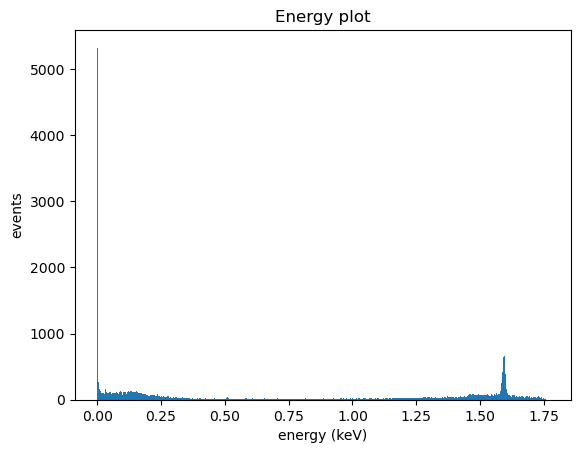

In [78]:
# plot the energy
plot_hist(tracks, binning = 1000)

In [21]:
# testing gth_lth_cuts logic
display(tracks.head())
# we'll remove event 360004 trackID 1 by applying cut < 22mm for xmin
display((tracks[(abs(tracks['x_min']) >= 22)]).head())
print("Are arrays the same length with this cut applied?")
print(len((tracks[(abs(tracks['x_min']) >= 22)])) == len(tracks))
print("How about with a 0 cut?")
print(len((tracks[(abs(tracks['x_min']) >= 0)])) == len(tracks))
print("Checks out")

# but we care about radius, need to check if radius is ever negative.
print((tracks['r_max'] <= 0))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,1.031730,78.168773,70,6713,2,335.675,277.675,516.206040,...,520.127070,355.222946,327.965622,553.191316,0.639864,0.143497,0.000000,9.836735,9.363636,4.94982
1,0,1,0.112234,14.454749,5,997,2,-104.325,239.675,373.405042,...,375.623318,-90.208617,246.263128,379.057919,0.112234,0.112234,0.112234,9.836735,9.363636,4.94982
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.000000,9.250000,9.545455,4.31097
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.000000,9.857143,4.96313
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.000000,9.857143,4.96313


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,1.031730,78.168773,70,6713,2,335.675,277.675,516.206040,...,520.127070,355.222946,327.965622,553.191316,0.639864,0.143497,0.000000,9.836735,9.363636,4.94982
1,0,1,0.112234,14.454749,5,997,2,-104.325,239.675,373.405042,...,375.623318,-90.208617,246.263128,379.057919,0.112234,0.112234,0.112234,9.836735,9.363636,4.94982
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.000000,9.250000,9.545455,4.31097
3,4,0,1.324237,81.888779,69,6260,4,-372.325,-49.325,217.173285,...,277.944780,-339.612931,-27.498401,219.982249,0.813769,0.342792,0.000000,10.000000,9.857143,4.96313
4,4,1,0.284044,24.041484,10,1963,4,30.675,323.675,428.859480,...,434.062967,35.955470,331.871129,434.572544,0.283945,0.283941,0.283843,10.000000,9.857143,4.96313


Are arrays the same length with this cut applied?
False
How about with a 0 cut?
True
Checks out
0        False
1        False
2        False
3        False
4        False
         ...  
49641    False
49642    False
49643    False
49644    False
49645    False
Name: r_max, Length: 49646, dtype: bool


In [22]:
'''def gth_lth_cuts(df, column_title, one_sided = False, lower_lim = 0, upper_lim = 0, absolute = True):
    #applies cut on column via upper and lower limits (greater than, lesser than)
    #column title for two sided should be a tuple!

    # double sided
    if (one_sided==False):
        # conditional absolute for fiducial case, so include negative values within this range.
        if (absolute == True):
            filt_df = df[(abs(df[column_title[0]]) >= lower_lim) & (abs(df[column_title[1]]) <= upper_lim)]
        else:
            filt_df = df[(df[column_title[0]] >= lower_lim) & (df[column_title[1]] <= upper_lim)]
    # one sided (lower or upper limit)
    else:
        # set greater or lesser based on lower or upper limit being 0
        print("placeholder")
'''
'''
def fiducial_track_cut(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    
    # Bespoke cutting algorithm for NEXT100 isaura which cuts for fiducial volume
    # z is contrained in a two-sided fashion (greater and less than), while R is taken not treated is one-sided.
    
    # create list of events that are outside the fiducial area
    z_df = df[(df['z_min'] <= lower_z) & (df['z_max'] >= upper_z)]
    rz_df = z_df[(z_df['r_max'] >= r_lim)]
    print(rz_df['event'])


    # z filtering
    filt_z_df = df[(df['z_min'] >= lower_z) & (df['z_max'] <= upper_z)] # mm

    # r filtering
    filt_df = filt_z_df[(filt_z_df['r_max'] <= r_lim)]

    # these two create masks, then you need to collect the events to preserve based on this.

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))

    return filt_df
'''


def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3



In [23]:
def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events

In [24]:
def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove
    

In [25]:
def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df


In [26]:
def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1


##### Now lets look at the fiducial selection parameters to get a feeling of whats going on

In [27]:
def plot_volume_hists(df):

    plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

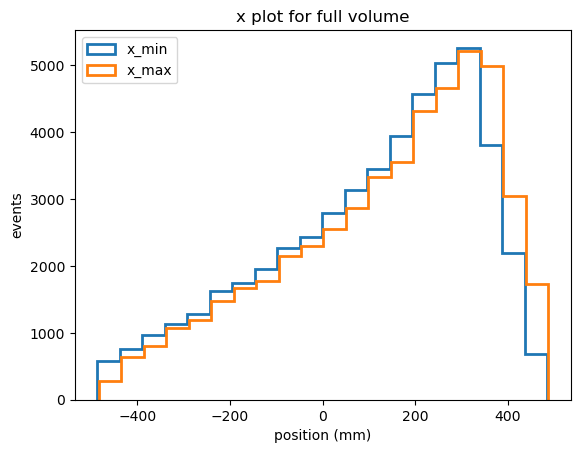

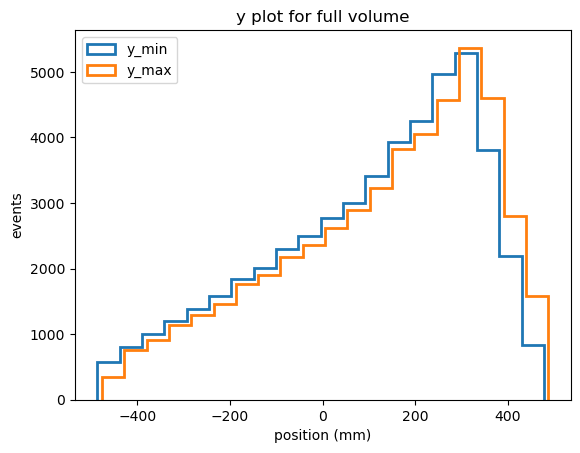

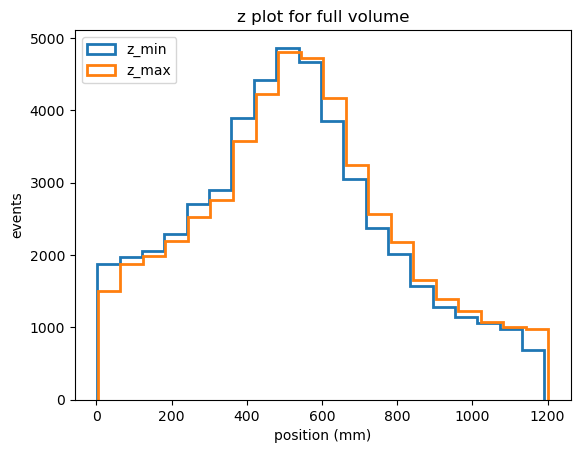

In [28]:
plot_volume_hists(tracks)

##### Considering the fiducial limits, this looks okay?
Limits:
- 20mmm < z < 1195mm
- r < 472mm (x and y limits in the -ve and negative)

Although the 472 radius seems really generous, maybe that cut has already been made? lets do a test


In [29]:
# checking what the largest x position is
x_max_max = tracks['x_max'].max()
print("Largest x_max values: {:.2f}".format(x_max_max))

Largest x_max values: 486.68


##### So this is outside the fiducial volume, this seems okay. Looking at when binning is changed from 20 -> 50, saw only artifacts in the z section.

##### So now to apply fiducial cuts

In [30]:
# for easy tracking
cut_names = []
rel_cut_effics = []
abs_cut_effics = []
cut_events = []

# no cuts
cut_names.append("No cuts")
rel_cut_effics.append(100)
abs_cut_effics.append(100)
# number of events
cut_events.append(len_events(tracks))

cut_names.append("Fiducial Cuts")

# make fiducial cuts
fiducial = fiducial_track_cut_2(tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = True)

# make efficiency calculation
ef = cut_effic(fiducial, tracks)

# add efficiency calculation
rel_cut_effics.append(ef)
cut_events.append(len_events(fiducial))
abs_cut_effics.append(ef)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Efficiency: 71.95 %


##### And the one track cut

In [31]:
# relative

cut_names.append("One track cut")
one_track_rel = one_track_cuts(fiducial, verbose = True)

# events are relative, as absolute efficiency lets you figure out events from the beginning# absolute
one_track_abs = one_track_cuts(tracks)

## sanity check here
#print(len_events(one_track_rel), len_events(one_track_abs), len_events(tracks))

# relative
print("Single track cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(one_track_rel, fiducial)
rel_cut_effics.append(ef)
cut_events.append(len_events(one_track_rel))

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(one_track_abs, tracks)
abs_cut_effics.append(ef)

Removing events with more than one track.
Events with one track: Int64Index([      2,       6,      10,      12,      14,      16,      22,
                 28,      30,      34,
            ...
            7960184, 7960188, 7960194, 7960198, 7960212, 7960220, 7960228,
            7960232, 7960238, 7960244],
           dtype='int64', name='event', length=10540)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.0,9.250000,9.545455,4.310970
7,6,0,1.466383,58.545117,64,5961,1,216.675,178.675,508.637902,...,511.999816,229.008420,201.182692,553.531317,0.695194,0.581122,0.0,8.250000,9.666667,4.781579
12,10,0,1.598264,90.017410,83,6868,1,304.675,70.675,558.203362,...,560.917601,312.928268,137.990505,605.108996,0.660614,0.463501,0.0,10.000000,9.250000,4.575876
13,12,0,1.629635,128.330191,99,6883,1,167.675,326.675,559.875487,...,562.606480,238.081786,358.091384,639.517115,0.844407,0.176924,0.0,9.111111,9.250000,4.839660
14,14,0,1.596058,63.028164,68,6657,1,259.675,196.675,600.194752,...,602.060195,279.651247,203.350030,633.651666,1.064407,0.298341,0.0,7.750000,8.500000,4.613588


Single track cut
Relative Cut efficiency:
Efficiency: 55.36 %
Absolute Cut efficiency:
Efficiency: 49.34 %


#### Plot the spacial stuff and compare

Looks good to me

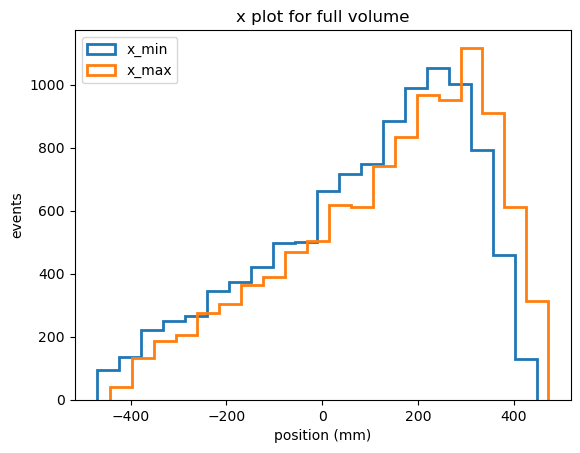

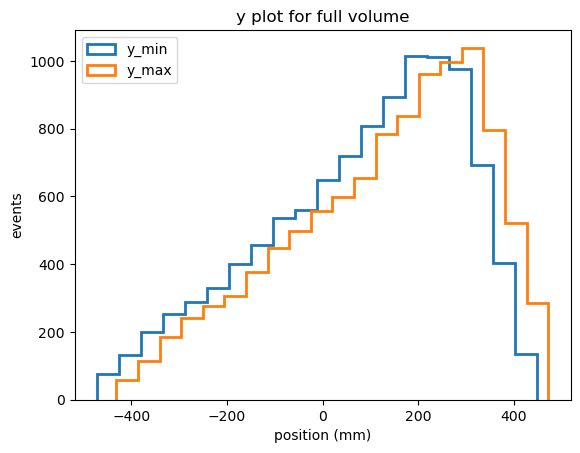

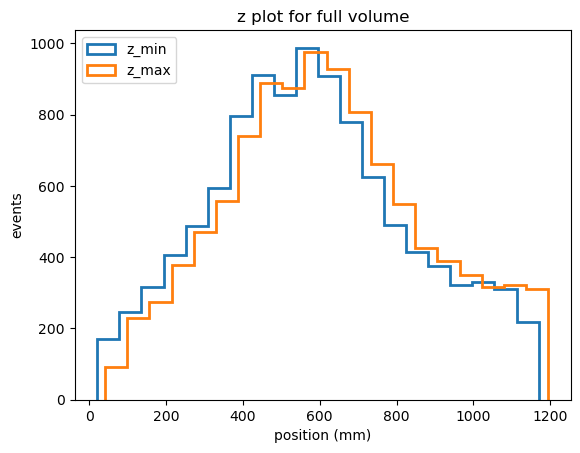

In [32]:
plot_volume_hists(one_track_rel)

#### No overlapping blobs

I have to assume this is achieved by setting ovlp_blob_energy, but lets look at these values and see if thats easy.

In [33]:
display(one_track_rel['ovlp_blob_energy'])


2        0.0
7        0.0
12       0.0
13       0.0
14       0.0
        ... 
49613    0.0
49614    0.0
49634    0.0
49638    0.0
49645    0.0
Name: ovlp_blob_energy, Length: 10540, dtype: float64

Seems to have a lot of values at zero, so I think this is an acceptable cut method

In [34]:
# apply cuts
ovlp_rel = overlapping_cuts(one_track_rel)
ovlp_abs = overlapping_cuts(tracks)

In [35]:
cut_names.append("Blob overlap cuts")


# relative
print("Blob overlap cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ovlp_rel, one_track_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ovlp_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ovlp_rel, tracks)
abs_cut_effics.append(ef)

Blob overlap cut
Relative Cut efficiency:
Efficiency: 83.45 %
Absolute Cut efficiency:
Efficiency: 33.24 %


#### Energy cut

Want to limit range from [1.5, 1.7] MeV

In [36]:
ecut_rel = energy_cuts(ovlp_rel)
ecut_abs = energy_cuts(tracks)

cut_names.append("Energy cuts")

# relative
print("Energy cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ecut_rel, ovlp_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ecut_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ecut_rel, tracks)
abs_cut_effics.append(ef)

Energy cut
Relative Cut efficiency:
Efficiency: 77.29 %
Absolute Cut efficiency:
Efficiency: 25.69 %


#### Print cut efficiency relative and absolute as a table and plot the energy of the final cuts

In [37]:
efficiencies = pd.DataFrame({'Cut': cut_names,
                             'Relative Efficiency': rel_cut_effics,
                             'Single Cut Efficiency': abs_cut_effics,
                             'Relative Events': cut_events})

In [38]:
display(efficiencies)
# NOTE!!! THE EVENTS ARE RELATIVE. So to get the number of events by single cut,
# multiply the events against single cut efficiency

,Cut,Relative Efficiency,Single Cut Efficiency,Relative Events
0,No cuts,100.000000,100.000000,26461
1,Fiducial Cuts,71.951173,71.951173,19039
2,One track cut,55.360050,49.336760,10540
3,Blob overlap cuts,83.453510,33.241374,8796
4,Energy cuts,77.285130,25.690639,6798


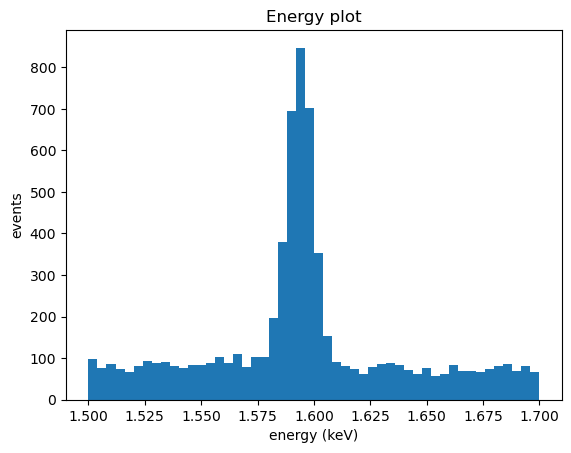

In [79]:
# plot energy of final
plot_hist(ecut_rel, binning = 50)

#### Histogram plotting showing the effect of all the cuts:

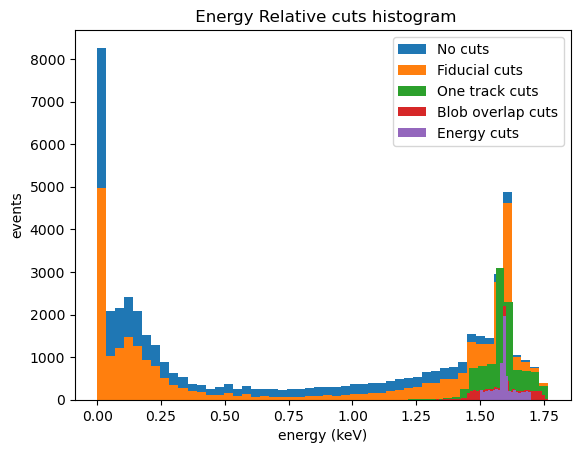

In [40]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50)
plot_hist(one_track_rel, label = 'One track cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'Blob overlap cuts', output = False, binning = 50)
plot_hist(ecut_rel, label = 'Energy cuts', output = False, title=' Energy Relative cuts histogram')
plt.legend()
plt.show()

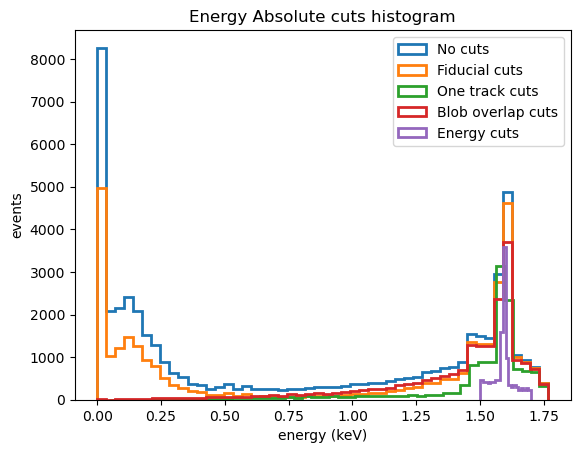

In [41]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50, fill = False)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50, fill = False)
plot_hist(one_track_abs, label = 'One track cuts', output = False, binning = 50, fill = False)
plot_hist(ovlp_abs, label = 'Blob overlap cuts', output = False, binning = 50, fill = False)
plot_hist(ecut_abs, label = 'Energy cuts', output = False, title='Energy Absolute cuts histogram', fill = False)
plt.legend()
plt.show()

##### Lets do the same but exclude the final energy cut and log it

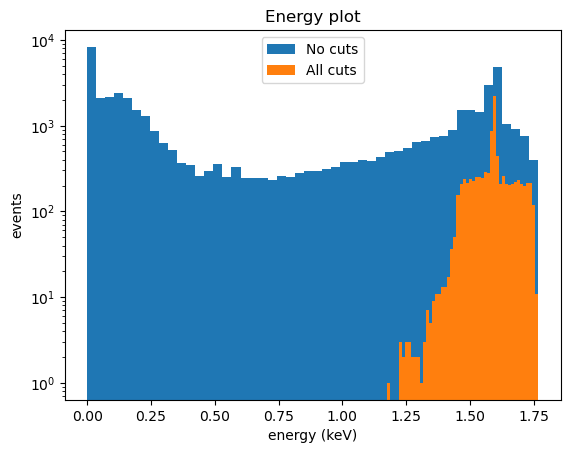

In [42]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'All cuts', output = False, binning = 50)
plt.yscale('log')
plt.legend()
plt.show()

0.012222451387873017 1.5414293597309054


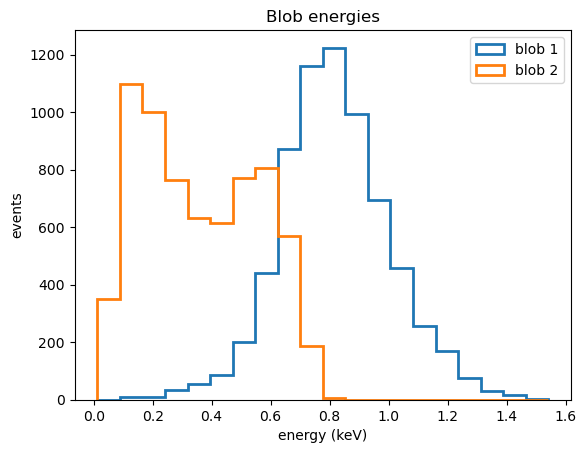

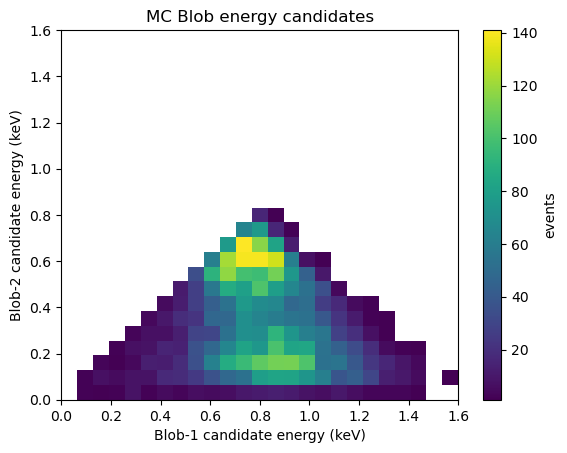

In [43]:
# produce nicer plots, this is energy histograms for the blobs post-all cuts

# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
print(minimum_e, maximum_e)

plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(ecut_rel['eblob1'], ecut_rel['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (keV)")
plt.ylabel("Blob-2 candidate energy (keV)")
plt.title("MC Blob energy candidates")
plt.show()

In [44]:
display(ecut_rel)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.0,9.250000,9.545455,4.310970
12,10,0,1.598264,90.017410,83,6868,1,304.675,70.675,558.203362,...,560.917601,312.928268,137.990505,605.108996,0.660614,0.463501,0.0,10.000000,9.250000,4.575876
13,12,0,1.629635,128.330191,99,6883,1,167.675,326.675,559.875487,...,562.606480,238.081786,358.091384,639.517115,0.844407,0.176924,0.0,9.111111,9.250000,4.839660
14,14,0,1.596058,63.028164,68,6657,1,259.675,196.675,600.194752,...,602.060195,279.651247,203.350030,633.651666,1.064407,0.298341,0.0,7.750000,8.500000,4.613588
24,28,0,1.571658,75.427147,84,7755,1,305.675,97.675,864.773542,...,906.513841,309.927352,128.074334,868.932541,1.101221,0.171160,0.0,9.833333,9.600000,4.615312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49613,4680204,0,1.696455,109.843950,84,6564,1,-93.325,-111.325,192.819742,...,221.547021,-78.717010,-105.139391,226.896826,0.688662,0.071548,0.0,8.500000,9.400000,4.502587
49614,4680208,0,1.596950,65.825344,75,7022,1,-216.325,-288.325,534.685095,...,572.855439,-177.323188,-281.326831,541.777664,0.885635,0.525476,0.0,9.200000,8.250000,4.657794
49634,4680226,0,1.595162,65.513404,63,7005,1,-336.325,114.675,580.880842,...,584.041856,-307.186632,120.024645,620.710484,0.886098,0.367052,0.0,9.000000,8.666667,4.752405
49638,4680232,0,1.599234,77.159801,61,7104,1,-165.325,240.675,416.258299,...,429.565531,-124.399493,303.808883,419.011878,0.752307,0.604659,0.0,9.600000,10.000000,4.017242


#### Playing around with MC

Want to make a plot that shows the MC background here

In [45]:
# MC stuff taken from above
display(particles)
#display(eventmap.head(5))
display(ecut_rel.head())


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,1,Tl208,True,0,398.552155,393.709900,534.072693,0.000000,398.552155,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,0,4,e-,False,1,398.552155,393.709900,534.072693,0.000109,399.022034,...,0.601862,-0.459878,-0.888688,0.000000,0.000000,-0.000000,0.763604,1.378337,RadioactiveDecay,eIoni
2,0,3,anti_nu_e,False,1,398.552155,393.709900,534.072693,0.000109,-12500.000000,...,-0.965594,-0.378647,-0.028075,-0.965594,-0.378647,-0.028075,1.037561,13859.900391,RadioactiveDecay,Transportation
3,0,2,Pb208[3197.711],False,1,398.552155,393.709900,534.072693,0.000109,398.552155,...,0.363732,0.838525,0.916763,0.000000,0.000000,0.000000,0.000004,0.000000,RadioactiveDecay,RadioactiveDecay
4,0,6,gamma,False,2,398.552155,393.709900,534.072693,0.000109,412.761810,...,0.179433,0.241938,-0.499377,-0.000000,-0.000000,0.000000,0.583188,54.389122,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276179,4680238,58,e-,False,54,95.923363,46.652542,256.924255,2.163573,95.904709,...,0.119314,-0.034327,0.208870,-0.000000,0.000000,0.000000,0.054829,1.126255,eIoni,eIoni
2276180,4680238,57,e-,False,54,92.230873,37.294933,248.009125,2.024914,92.353096,...,0.144201,0.046931,-0.141077,-0.000000,0.000000,-0.000000,0.040380,0.923102,eIoni,eIoni
2276181,4680238,56,e-,False,54,127.466400,45.358784,275.228210,1.800889,127.682884,...,-0.122162,0.145911,0.264190,0.000000,0.000000,0.000000,0.094914,2.925962,eIoni,eIoni
2276182,4680238,53,e-,False,52,167.316360,45.347717,284.060333,1.632847,167.122787,...,-0.219095,-0.265649,-0.323633,-0.000000,-0.000000,0.000000,0.185011,9.379354,conv,eIoni


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.0,9.250000,9.545455,4.310970
12,10,0,1.598264,90.017410,83,6868,1,304.675,70.675,558.203362,...,560.917601,312.928268,137.990505,605.108996,0.660614,0.463501,0.0,10.000000,9.250000,4.575876
13,12,0,1.629635,128.330191,99,6883,1,167.675,326.675,559.875487,...,562.606480,238.081786,358.091384,639.517115,0.844407,0.176924,0.0,9.111111,9.250000,4.839660
14,14,0,1.596058,63.028164,68,6657,1,259.675,196.675,600.194752,...,602.060195,279.651247,203.350030,633.651666,1.064407,0.298341,0.0,7.750000,8.500000,4.613588
24,28,0,1.571658,75.427147,84,7755,1,305.675,97.675,864.773542,...,906.513841,309.927352,128.074334,868.932541,1.101221,0.171160,0.0,9.833333,9.600000,4.615312


In [46]:
# lets look at some 'True' primary events
prim_parts = particles['primary']
print(prim_parts.any()) # checks for true, false if otherwise

True


#### So collect all the events that are e+ and plot those alongside the blob energies plot to show how much is e+e- background :)

In [47]:
# create e+ dataframe only
positron_df = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events = positron_df.append(particles.loc[condition], ignore_index=True)
display(positron_events)

# collect events
pos_events = np.unique(positron_events['event_id'].to_numpy())
print("Number of positron events: {}".format(len(pos_events)))
print(pos_events)

## remove non-unique numbers (NO NEED TO DO THIS AS THERE SHOULD ONLY BE ONE POSITRON 
##                              PER EVENT)
#unique_elements, counts = np.unique(pos_events, return_counts=True)
#unique_indices = np.where(counts ==1)[0]
#unique_events = unique_elements[unique_indices]
#print(unique_events[10:20])



,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,2,29,e+,False,27,321.102417,265.314636,524.614014,0.503568,274.392487,...,-0.915680,-1.681576,0.531289,-0.0,0.0,0.0,1.540721,173.625320,conv,annihil
1,10,48,e+,False,46,319.914703,127.301018,601.601257,0.958700,315.770477,...,-0.323372,-0.183624,-0.569461,-0.0,0.0,0.0,0.339703,24.842295,conv,annihil
2,14,46,e+,False,44,285.185577,206.187149,629.463928,0.801738,283.181183,...,0.461672,-0.071208,-0.016710,-0.0,0.0,0.0,0.181541,10.932988,conv,annihil
3,24,20,e+,False,18,273.521515,388.240082,414.347717,0.565324,281.863831,...,-0.622840,0.002428,-1.033400,-0.0,-0.0,0.0,0.799333,77.534416,conv,annihil
4,32,31,e+,False,29,355.963623,320.123871,416.218628,0.488680,339.128387,...,-0.405917,-0.588960,-1.153894,0.0,-0.0,0.0,0.939599,91.614845,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9165,4680208,47,e+,False,45,-184.620163,-256.886200,568.781982,2.918440,-204.499985,...,-0.949674,-0.806105,-0.263307,-0.0,0.0,-0.0,0.860911,68.683685,conv,annihil
9166,4680212,25,e+,False,23,-129.489594,304.055115,327.598389,1.919218,-127.775963,...,-0.958127,-0.092162,-0.753776,-0.0,0.0,-0.0,0.814067,76.657959,conv,annihil
9167,4680226,23,e+,False,21,-312.287140,123.472260,616.561523,2.557224,-309.190643,...,-0.547777,-0.195926,0.055043,-0.0,-0.0,0.0,0.265272,20.474491,conv,annihil
9168,4680232,23,e+,False,21,-124.003548,301.352570,420.107971,1.802063,-156.326385,...,-1.603989,-0.429705,-0.314768,0.0,0.0,-0.0,1.254681,118.218262,conv,annihil


Number of positron events: 9170
[2 10 14 ... 7960238 7960240 7960244]


In [48]:
# collect all events that match this list
ecut_no_positron_df = ecut_rel[~ecut_rel['event'].isin(pos_events)]

display(ecut_no_positron_df)

# events with positrons only in here!
ecut_positron_df = ecut_rel[ecut_rel['event'].isin(pos_events)]

display(ecut_positron_df)

# Check that we get all the data, should print true (which it does) 
print(len(ecut_positron_df) + len(ecut_no_positron_df) == len(ecut_rel))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
13,12,0,1.629635,128.330191,99,6883,1,167.675,326.675,559.875487,...,562.606480,238.081786,358.091384,639.517115,0.844407,0.176924,0.0,9.111111,9.250000,4.839660
24,28,0,1.571658,75.427147,84,7755,1,305.675,97.675,864.773542,...,906.513841,309.927352,128.074334,868.932541,1.101221,0.171160,0.0,9.833333,9.600000,4.615312
29,34,0,1.557519,106.231502,106,6252,1,270.675,97.675,1057.150500,...,1125.397548,308.325627,144.184907,1060.281406,0.815081,0.302857,0.0,8.800000,8.833333,4.757417
34,42,0,1.691018,65.088624,78,6069,1,-263.325,-204.325,453.211447,...,474.231971,-259.950264,-164.753644,478.056291,1.007948,0.074382,0.0,8.857143,8.500000,4.614212
42,50,0,1.581367,63.235296,64,7087,1,269.675,249.675,719.463465,...,741.266137,307.103447,299.623077,721.293977,1.121274,0.158796,0.0,8.400000,9.333333,4.890576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49600,4680184,0,1.639865,86.142584,67,6613,1,-112.325,262.675,313.747481,...,331.932627,-62.745679,329.087690,315.707869,1.213432,0.057472,0.0,9.333333,9.125000,4.193516
49607,4680192,0,1.648762,75.420361,66,6535,1,125.675,193.675,437.250292,...,456.058070,196.287928,214.791386,454.671345,1.091133,0.191564,0.0,9.500000,9.333333,4.186350
49609,4680196,0,1.560229,67.184664,89,6916,1,40.675,201.675,635.464672,...,638.084135,76.736855,224.329123,684.531496,0.967188,0.155253,0.0,8.400000,8.000000,4.654726
49611,4680200,0,1.685090,51.019487,70,7062,1,-23.325,196.675,1076.456430,...,1099.746516,22.261410,214.813363,1089.854984,0.908625,0.582543,0.0,8.666667,7.750000,4.617366


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
2,2,0,1.591866,121.588786,99,6983,1,261.675,165.675,509.478795,...,527.953997,320.487461,263.448068,525.532944,0.575633,0.178668,0.0,9.250000,9.545455,4.310970
12,10,0,1.598264,90.017410,83,6868,1,304.675,70.675,558.203362,...,560.917601,312.928268,137.990505,605.108996,0.660614,0.463501,0.0,10.000000,9.250000,4.575876
14,14,0,1.596058,63.028164,68,6657,1,259.675,196.675,600.194752,...,602.060195,279.651247,203.350030,633.651666,1.064407,0.298341,0.0,7.750000,8.500000,4.613588
33,40,0,1.587190,61.016156,68,6343,1,7.675,-231.325,94.555939,...,129.183119,15.164056,-224.242332,101.855195,0.718570,0.527887,0.0,9.666667,10.000000,4.744354
77,82,0,1.588259,65.980202,57,6763,1,-229.325,-253.325,388.540819,...,435.532132,-221.384142,-224.375034,391.545750,0.729236,0.629526,0.0,10.000000,9.750000,4.573468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49613,4680204,0,1.696455,109.843950,84,6564,1,-93.325,-111.325,192.819742,...,221.547021,-78.717010,-105.139391,226.896826,0.688662,0.071548,0.0,8.500000,9.400000,4.502587
49614,4680208,0,1.596950,65.825344,75,7022,1,-216.325,-288.325,534.685095,...,572.855439,-177.323188,-281.326831,541.777664,0.885635,0.525476,0.0,9.200000,8.250000,4.657794
49634,4680226,0,1.595162,65.513404,63,7005,1,-336.325,114.675,580.880842,...,584.041856,-307.186632,120.024645,620.710484,0.886098,0.367052,0.0,9.000000,8.666667,4.752405
49638,4680232,0,1.599234,77.159801,61,7104,1,-165.325,240.675,416.258299,...,429.565531,-124.399493,303.808883,419.011878,0.752307,0.604659,0.0,9.600000,10.000000,4.017242


True


In [49]:
'''
# trying the same thing again but with Helenas method?
withpositron_list = particles[particles['particle_name'] == 'e+']['event_id'].unique()
event_nopos_sel = ecut_rel.event.isin(withpositron_list)

ecut_rel_withpos = ecut_rel[event_nopos_sel]

display(ecut_rel_withpos)

# stolen from Helena's code, will understand it better once I get it to work
# i dont need to understand it, as my code works fine without this. Can remove if wanted

no_pos_blob1 = []
no_pos_blob2 = []
no_pos_e = []


for evt in ecut_rel.event.unique():
    ecut_rel_evt = ecut_rel[ecut_rel.event == evt]

    posi_evt = ecut_rel_withpos[ecut_rel_withpos.event == evt]
    try:
        print("Positron")
        posi_evt.x_min.values[0]
    except:
        print('no positron')
        no_pos_blob1.append(ecut_rel_evt.eblob1.values[0])
        no_pos_blob2.append(ecut_rel_evt.eblob2.values[0])
        no_pos_e.append(ecut_rel_evt.energy.values[0])

# produce nicer plots, this is energy histograms for the blobs post-all cuts


plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

#plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
#plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

'''

'\n# trying the same thing again but with Helenas method?\nwithpositron_list = particles[particles[\'particle_name\'] == \'e+\'][\'event_id\'].unique()\nevent_nopos_sel = ecut_rel.event.isin(withpositron_list)\n\necut_rel_withpos = ecut_rel[event_nopos_sel]\n\ndisplay(ecut_rel_withpos)\n\n# stolen from Helena\'s code, will understand it better once I get it to work\n# i dont need to understand it, as my code works fine without this. Can remove if wanted\n\nno_pos_blob1 = []\nno_pos_blob2 = []\nno_pos_e = []\n\n\nfor evt in ecut_rel.event.unique():\n    ecut_rel_evt = ecut_rel[ecut_rel.event == evt]\n\n    posi_evt = ecut_rel_withpos[ecut_rel_withpos.event == evt]\n    try:\n        print("Positron")\n        posi_evt.x_min.values[0]\n    except:\n        print(\'no positron\')\n        no_pos_blob1.append(ecut_rel_evt.eblob1.values[0])\n        no_pos_blob2.append(ecut_rel_evt.eblob2.values[0])\n        no_pos_e.append(ecut_rel_evt.energy.values[0])\n\n# produce nicer plots, this is en

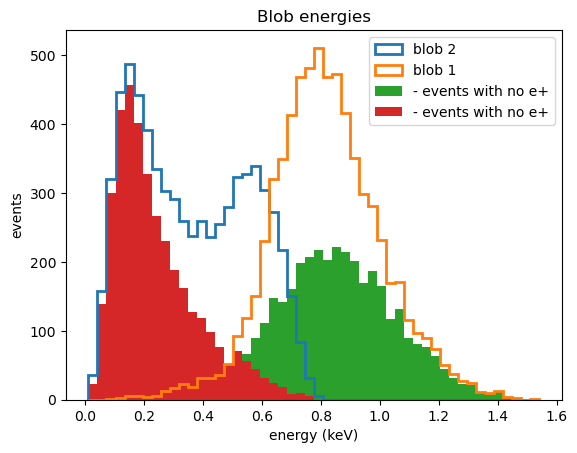

In [50]:
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()


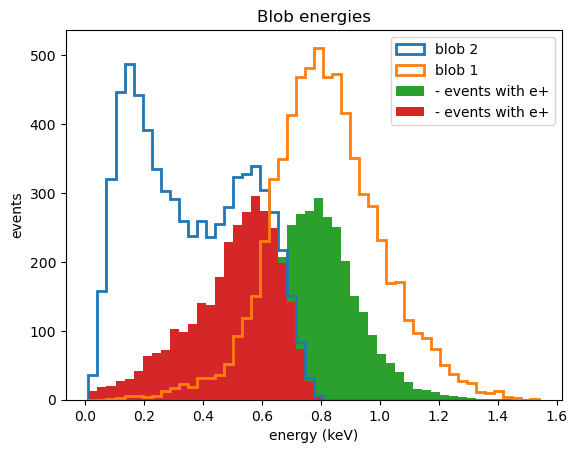

In [51]:
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_positron_df, column = 'eblob1', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))
plot_hist(ecut_positron_df, column = 'eblob2', binning = 50, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (keV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()


Trying this now with the energy only

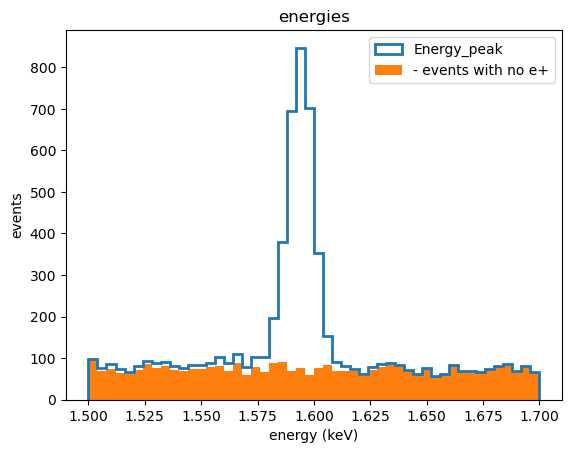

In [52]:
plot_hist(ecut_rel, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = 'Energy_peak', x_label = 'energy (keV)')
plot_hist(ecut_no_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (keV)')

plt.legend()
plt.show()

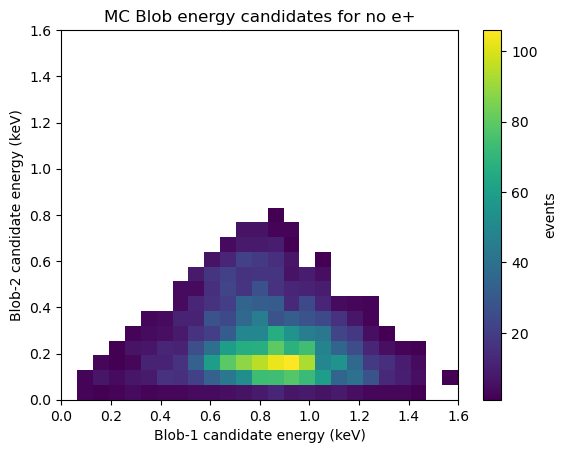

In [53]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_no_positron_df['eblob1'], ecut_no_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (keV)")
plt.ylabel("Blob-2 candidate energy (keV)")
plt.title("MC Blob energy candidates for no e+")
plt.show()

#### Apply the fitting to our energy cuts

first goes the big function

In [54]:
def expo(x, tau):
        return np.exp(-x/tau)
    
def gauss1_erfc(x, mu, sigma, const2, const3):
    if sigma <= 0.:
        return np.inf
    func = (const3 + const2*special.erfc((x-mu)/sigma) + 
            1./(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.))    
    return func

def skewnorm_fc(x, mu, const2, const3, ask, scale):
    func = (const3 + const2*special.erfc(2*(x-mu)/scale) + skewnorm.pdf(x,ask, mu, scale))  
    return func

def get_chi2_s(x, y, sfunc):
    nt        = [s_func(xi, fit_result.values['mu' ], fit_result.values['sigma'], fit_result.values['const2'], fit_result.values['const3'], fit_result.values['Ns']) for xi in x]
    nt        = np.array(nt)
    nt        = nt * y.max()/nt.max()
    return chisquare(y, nt)[0]/len(y-1)

def get_chi2_sb(x, y, sfunc, bfunc):
    nt        = [s_func(xi, fit_result.values['mu' ], fit_result.values['sigma'], fit_result.values['const2'], fit_result.values['const3'],   fit_result.values['Ns']) +
                 b_func(xi, fit_result.values['tau'], fit_result.values['Nb']) for xi in x]    
    nt        = np.array(nt)
    nt        = nt * y.max()/nt.max()
    return chisquare(y, nt)[0]/len(y-1)

def fit_umle_s2(fit_range, energies, unbinned, mu, b, c2, c3, a, fix_const=False, fix_gauss=False, fPlot=False, nbins=80):
    binning   = np.linspace(*fit_range, nbins+1)
    y, x      = np.histogram(energies, binning)
    x         = coref.shift_to_bin_centers(x)
    index0    = int(len(x)/6)
    index1    = int(5*len(x)/6)
    enrgPre   = x[index0]
    enrgPost  = x[index1]
    backgPre  = np.mean(y[index0-2:index0+2])
    backPost  = np.mean(y[index1-2:index1+2])
    tau_seed  = 1/np.abs(np.log(backgPre/backPost)/(enrgPre-enrgPost))
    pars = dict(Ns=len(energies), mu=mu, const2 = c2, const3 = c3, ask = a, scale = b)
    
    minuit = iminuit.Minuit(unbinned, **pars)  
    
    minuit.migrad()
    if fPlot:
        unbinned.show(bins=80, parts=True);
    xy = [x,y]
    return minuit, xy
def fit_umle_s(fit_range, energies, unbinned, mu, sigma, c2, c3, fix_const=False, fix_gauss=False, fPlot=False, nbins=80):
    binning   = np.linspace(*fit_range, nbins+1)
    y, x      = np.histogram(energies, binning)
    x         = coref.shift_to_bin_centers(x)
    index0    = int(len(x)/6)
    index1    = int(5*len(x)/6)
    enrgPre   = x[index0]
    enrgPost  = x[index1]
    backgPre  = np.mean(y[index0-2:index0+2])
    backPost  = np.mean(y[index1-2:index1+2])
    tau_seed  = 1/np.abs(np.log(backgPre/backPost)/(enrgPre-enrgPost))
    pars = dict(Ns=len(energies), mu=mu, sigma=sigma, const2=c2, const3=c3)
    minuit = iminuit.Minuit(unbinned, **pars)
    if fix_gauss:
        minuit.fixed['mu'] = mu
        minuit.fixed['sigma'] = sigma
    if fix_const:
        minuit.fixed['const2'] = c2
        minuit.fixed['const3'] = c3
    minuit.migrad()
    if fPlot:
        unbinned.show(bins=80, parts=True);
    xy = [x,y]
    return minuit, xy
def fit_umle_sb(fit_range, energies, unbinned, mu, sigma, c2, c3, fix_const=False, fix_gauss=False, fPlot=False, nbins=80):
    binning   = np.linspace(*fit_range, nbins+1)
    y, x      = np.histogram(energies, binning)
    x         = coref.shift_to_bin_centers(x)
    index0    = int(len(x)/6)
    index1    = int(5*len(x)/6)
    enrgPre   = x[index0]
    enrgPost  = x[index1]
    backgPre  = np.mean(y[index0-2:index0+2])
    backPost  = np.mean(y[index1-2:index1+2])
    tau_seed  = 1/np.abs(np.log(backgPre/backPost)/(enrgPre-enrgPost))
    pars = dict(Ns=len(energies),Nb=len(energies)*0.5, tau=tau_seed, mu=mu, sigma=sigma, const2=c2, const3=c3)
    minuit = iminuit.Minuit(unbinned, **pars)
    minNb = 0
    for i in (energies > 1625):
        if i: minNb+=1
    if fix_gauss:
        minuit.limits['mu'] = (mu-50, mu+50)
        minuit.fixed['sigma'] = sigma
    if fix_const:
        minuit.fixed['const2'] = c2
        minuit.fixed['const3'] = c3
    minuit.limits['Nb'] = (0, len(energies)-minNb)
    minuit.limits['Ns'] = (minNb, len(energies))

    minuit.migrad()
    if fPlot:
        unbinned.show(bins=80, parts=True);
    xy = [x,y]
    return minuit, xy

def fit_umle_sb2(fit_range, energies, unbinned, mu, b, c2, c3, a, fix_const=False, fix_gauss=False, fPlot=False, nbins=80):
    binning   = np.linspace(*fit_range, nbins+1)
    y, x      = np.histogram(energies, binning)
    x         = coref.shift_to_bin_centers(x)
    index0    = int(len(x)/6)
    index1    = int(5*len(x)/6)
    enrgPre   = x[index0]
    enrgPost  = x[index1]
    backgPre  = np.mean(y[index0-2:index0+2])
    backPost  = np.mean(y[index1-2:index1+2])
    tau_seed  = 1/np.abs(np.log(backgPre/backPost)/(enrgPre-enrgPost))
    pars = dict(Ns=len(energies),Nb=len(energies)*0.5,tau=tau_seed, mu=mu, const2 = c2, const3 = c3, ask = a, scale = b)
    minuit = iminuit.Minuit(unbinned, **pars)  
    minNb = 0
    for i in (energies > 1625):
        if i: minNb+=1
    if fix_gauss:
        minuit.limits['mu'] = (mu-50, mu+50)
        minuit.fixed['scale'] = b
    if fix_const:
        minuit.fixed['const2'] = c2
        minuit.fixed['const3'] = c3
    minuit.limits['Nb'] = (0, len(energies)-minNb)
    minuit.limits['Ns'] = (minNb, len(energies))
    
    minuit.migrad()
    if fPlot:
        unbinned.show(bins=80, parts=True);
    xy = [x,y]
    return minuit, xy

def count_signal_bckg(fit_result, sfun, bfun):
    s_wide     = fit_result.values['Ns']
    err_s_wide = fit_result.errors['Ns']
    b_wide     = fit_result.values['Nb']
    err_b_wide = fit_result.errors['Nb']
    mu         = fit_result.values['mu']
    err_mu     = fit_result.errors['mu']
    sigma      = fit_result.values['sigma']
    err_sigma  = fit_result.errors['sigma']
    tau        = fit_result.values['tau']
    err_tau    = fit_result.errors['tau']
    const2     = fit_result.values['const2']
    err_const2 = fit_result.errors['const2']
    const3     = fit_result.values['const3']
    err_const3 = fit_result.errors['const3']
    e_min, e_max = mu - 3. * sigma, mu + 3. * sigma
    integral_sig  = integrate.quad(sfun , e_min, e_max, args=(mu, sigma, const2, const3, s_wide))
    integral_bckg = integrate.quad(bfun , e_min, e_max, args=(tau, b_wide))
    s = integral_sig[0]
    b = integral_bckg[0]
    s_err = np.sqrt(np.sqrt(s)**2 + integral_sig [1]**2 + err_s_wide**2)
    b_err = np.sqrt(np.sqrt(b)**2 + integral_bckg[1]**2 + (err_b_wide * b/b_wide)**2)
    return [s, s_err], [b, b_err]

def count_signal_bckg2(fit_result, sfun, bfun):
    s_wide     = fit_result.values['Ns']
    err_s_wide = fit_result.errors['Ns']
    b_wide     = fit_result.values['Nb']
    err_b_wide = fit_result.errors['Nb']
    mu         = fit_result.values['mu']
    err_mu     = fit_result.errors['mu']
    scale      = fit_result.values['scale']
    err_scale  = fit_result.errors['scale']
    tau        = fit_result.values['tau']
    err_tau    = fit_result.errors['tau']
    const2     = fit_result.values['const2']
    err_const2 = fit_result.errors['const2']
    const3     = fit_result.values['const3']
    err_const3 = fit_result.errors['const3']
    ask     = fit_result.values['ask']
    err_ask = fit_result.errors['ask']
    e_min, e_max = mu - 3. * (scale/2), mu + 3. * (scale/2)
    
    integral_sig  = integrate.quad(sfun , e_min, e_max, args=(mu, const2, const3, ask, scale, s_wide))
    print(mu, scale, const2, const3, ask, s_wide)
    integral_bckg = integrate.quad(bfun , e_min, e_max, args=(tau, b_wide))
    s = integral_sig[0]
    b = integral_bckg[0]
    s_err = np.sqrt(np.sqrt(s)**2 + integral_sig [1]**2 + err_s_wide**2)
    b_err = np.sqrt(np.sqrt(b)**2 + integral_bckg[1]**2 + (err_b_wide * b/b_wide)**2)
    return [s, s_err], [b, b_err]

In [55]:
pdf        = s_func
energies   = np.array(reco_withpositron[0])
umle       = probfit.UnbinnedLH(pdf, energies, extended=True)

y, x, _ = plt.hist(energies, nbins)
plt.xlabel('Track energy (keV)')
plt.ylabel('Counts/bin')

fit_result, binned = fit_umle_s(erange, energies, umle, 1600, 7, c2=4e-4, c3=8e-5, fix_const=False, fix_gauss=False, fPlot=True, nbins=nbins)
mu_fit         = fit_result.values['mu']
sigma_fit      = fit_result.values['sigma']
const2_fit     = fit_result.values['const2']
const3_fit     = fit_result.values['const3']

NameError: name 's_func' is not defined

In [ ]:
# collect parameters of interest
erange  = [emin*1000, emax*1000]
nbins = 81
e_min_plot_one = erange[0]
e_max_plot_one = erange[1]
# idk why this is the way it is, but it is
fit_range = (erange[0], erange[1])

# 
expo_n     = probfit.Normalized(expo, fit_range)
b_func     = probfit.Extended  (expo_n, extname='Nb')
gauss_erfc = probfit.Normalized(gauss1_erfc, fit_range)
s_func     = probfit.Extended  (gauss_erfc, extname='Ns')
skew_n     = probfit.Normalized(skewnorm_fc, fit_range)
s_func2    = probfit.Extended  (skew_n, extname='Ns')

In [ ]:
pdf_sb = probfit.AddPdf(s_func2, b_func)
#energies   = np.array(reco_withpositron[0])
energies_sb   = tracks_ROIovlp1trackfid.energy.values

y, x, _ = plt.hist(energies_sb, nbins)
plt.xlabel('Track energy (keV)')
plt.ylabel('Counts/bin')
umle_sb       = probfit.UnbinnedLH(pdf_sb, energies_sb, extended=True)

fit_result, binned = fit_umle_sb2(erange, energies_sb, umle_sb, mu_fit, scale_fit, c2=const2_fit, c3=const3_fit, a=ask_fit, fix_const=True, fix_gauss=True, fPlot=True, nbins=nbins)


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# lets try this ourselves

def bck_funct(x, nb, tau):
    '''
    Function describing the background, an exponential with scaling from Nb and tau
    '''

    return nb*np.exp(-x/tau)

def skewnorm_fc():
    print("placeholder")


def error_func(x, mu, sigma):
    erfnc = special.erfc(E-)

def sig_funct(x, ns, a, mu, sigma, C1, C2):
    
    return ns * (skewnorm_fc(a, x, mu, sigma) + C1*error_func(x, mu, sigma) + C2)

In [82]:
# create gaussian initially for testing purposes
def gauss(x, a, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return a*np.exp(-numer/denom)




In [202]:
# and a print function
def print_parameters(popt,pcov,labels):
    '''
    Prints fitting parameters

    :param popt:        Fit parameters
    :param pcov:        Fit covariances
    :param labels:      Labels of parameters
    '''
    print('===============================')
    print("        Fitting output      ")
    print('===============================')
    for i in range(len(popt)):
        print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors
    print('===============================')
    return 0


# plot parameters for fit, similar to plot_hist
def plot_fit(function, x, popt, popt_label, output = False, colour = 'red', x_counts = 100000):
    '''
    plots a fit based on individual points and a function
    plots across a more continuous space, to reduce weird artifacting for low X numbers
    '''

    # take much more continuous x axis
    x_min = np.min(x)
    x_max = np.max(x)

    x_plot = np.linspace(x_min, x_max, num = x_counts, endpoint = True)

    y = function(x_plot, *popt)
    plt.plot(x_plot, y, label = 'fit', color = colour)
    for i in range(len(popt)):

        plt.text(1.5, 850 - 50*i, str(popt_label[i]) + ": " + str(round(popt[i], 5)))

    if (output == True):
        plt.show()
    else:
        return


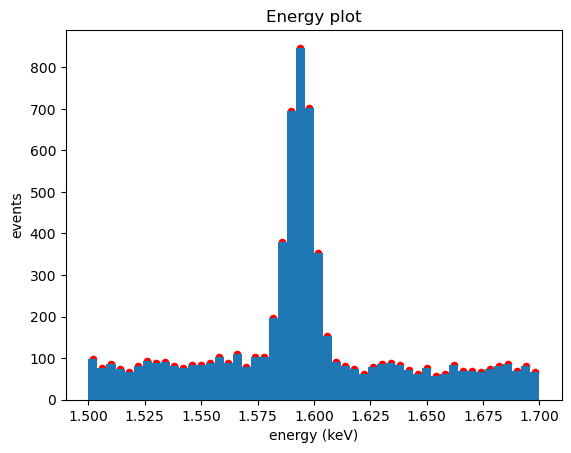

In [203]:
# try fitting gaussian
evalues = ecut_rel['energy'].to_numpy()

e_low = np.min(evalues) 
e_high = np.max(evalues)

# collect heights from histogram of energy
hist, edges, patches = plot_hist(ecut_rel, binning = 50, output = False, data = True)
# convert edges to centres
centres = shift_to_bin_centers(edges)

plt.scatter(centres, hist, color='red', s = 20)
plt.show()

In [204]:
# fit gaussian to this

# p0 is the initial guesses
p0 = ([800, 1.58, 0.04])
gauss_labels = ['a', 'mu','sigma']

popt, pcov = curve_fit(gauss, centres, hist, p0, maxfev = 500000)


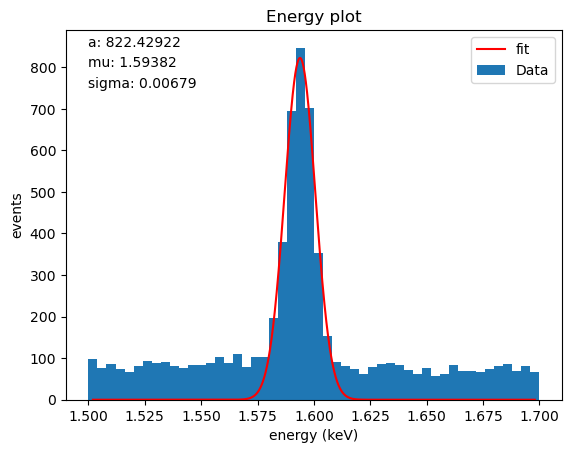

        Fitting output      
a: 822.4292 ± 53.7774
mu: 1.5938 ± 0.0005
sigma: 0.0068 ± 0.0005


0

In [205]:
plot_fit(gauss, centres, popt, gauss_labels)
plot_hist(ecut_rel, binning = 50, output = False, data = True, label='Data')
plt.legend()
plt.show()
print_parameters(popt, pcov, gauss_labels)

#### Create fom for blob 2 cuts

## Graveyard, all old code here

In [ ]:
# adding a break in here so when you do 'run all' it stops here
break;

SyntaxError: 'break' outside loop (1414924491.py, line 2)

In [ ]:
# testing fiducial cuts

'''def gth_lth_cuts(df, column_title, one_sided = False, lower_lim = 0, upper_lim = 0, absolute = True):
    #applies cut on column via upper and lower limits (greater than, lesser than)
    #column title for two sided should be a tuple!

    # double sided
    if (one_sided==False):
        # conditional absolute for fiducial case, so include negative values within this range.
        if (absolute == True):
            filt_df = df[(abs(df[column_title[0]]) >= lower_lim) & (abs(df[column_title[1]]) <= upper_lim)]
        else:
            filt_df = df[(df[column_title[0]] >= lower_lim) & (df[column_title[1]] <= upper_lim)]
    # one sided (lower or upper limit)
    else:
        # set greater or lesser based on lower or upper limit being 0
        print("placeholder")
'''
'''
def fiducial_track_cut(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    
    # Bespoke cutting algorithm for NEXT100 isaura which cuts for fiducial volume
    # z is contrained in a two-sided fashion (greater and less than), while R is taken not treated is one-sided.
    
    # create list of events that are outside the fiducial area
    z_df = df[(df['z_min'] <= lower_z) & (df['z_max'] >= upper_z)]
    rz_df = z_df[(z_df['r_max'] >= r_lim)]
    print(rz_df['event'])


    # z filtering
    filt_z_df = df[(df['z_min'] >= lower_z) & (df['z_max'] <= upper_z)] # mm

    # r filtering
    filt_df = filt_z_df[(filt_z_df['r_max'] <= r_lim)]

    # these two create masks, then you need to collect the events to preserve based on this.

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))

    return filt_df
'''


lower_z = 20
upper_z = 1195
r_lim = 472
# create list of events that are outside the fiducial area
z_df_low = tracks[(tracks['z_min'] <= lower_z)]
z_df_up = tracks[(tracks['z_max'] >= upper_z)]
r_df = tracks[(tracks['r_max'] >= r_lim)]
# printing it for understanding
display(z_df_low['event'].to_numpy()[:10])
# the numpy lists of events that need to be removed
df_low_list = (z_df_low['event'].to_numpy())
df_up_list = (z_df_up['event'].to_numpy())
r_list = (r_df['event'].to_numpy())

# then removing all events with these event numbers, lets start with event 112
display(tracks[:103])
# so you can see track 112 has z_min below lower_z
# all rows with event = 112 needs to go here.
remover = tracks[~tracks['event'].isin(df_low_list)]
display(remover[:103]) # does work!

#so lets functionalise this!




#### An aside, looking at the event chains